In [31]:
%autoreload 2

In [32]:
from argparse import Namespace
from collections import defaultdict
import copy
from datetime import datetime
import difflib
import gzip
import itertools
import multiprocessing
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import swifter
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer
from src.fitness_features_preprocessing import NGRAM_SCORE_PATTERN

In [33]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
# real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))

# regrown_game_asts = list(cached_load_and_parse_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl', grammar_parser, True, relative_path='..'))


In [34]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
print(fitness_df.shape)
original_game_counts = fitness_df.groupby('original_game_name').src_file.count().value_counts()
if len(original_game_counts) == 1:
    print(f'All original games have {original_game_counts.index[0] - 1} regrowths')  # type: ignore
else:
    print('Some original games have different numbers of regrowths: {original_game_counts}')
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']
(100450, 349)
All original games have 1024 regrowths


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,1.00,...,0.976714,0.984956,0.942266,0.970180,0.973574,0.978002,0.725160,0.761936,0.942521,0.975955
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,1.00,...,0.986443,0.986721,0.935275,0.965656,0.967074,0.978883,0.670913,0.801850,0.870098,0.924083
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,0.00,...,0.976849,0.981247,0.000000,0.000000,0.000000,0.000000,0.452633,0.593800,0.814709,0.883131
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,0.00,...,0.986600,0.986476,0.000000,0.000000,0.000000,0.000000,0.725160,0.761936,0.942521,0.975955
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0.25,...,0.985217,0.983768,0.000000,0.000000,0.000000,0.000000,0.937248,0.947704,0.933456,0.976437


# The 'train on more features' experiment
* Train model to convergence on some # of features
* Add more features (and increase model size)
* Continue training
* Evaluate

**TODO:** is this something about measuring statistics on the un-shuffled dataset at the end of training vs. training on the shuffled?


In [35]:
def get_features_by_abs_diff_threshold(diffs: pd.Series, score_threshold: float):
    feature_columns = list(diffs[diffs >= score_threshold].index)

    remove_all_ngram_scores = []  
    for score_type in ('full', 'setup', 'constraints', 'terminal', 'scoring'):
        col_names = sorted([c for c in feature_columns if c.startswith(f'ast_ngram_{score_type}') and c.endswith('_score')])

        if score_type not in remove_all_ngram_scores:
            col_names = col_names[:-1]

        for col in col_names:
            feature_columns.remove(col)

    return feature_columns


mean_features_by_real = fitness_df[['real'] + [c for c in fitness_df.columns if c not in NON_FEATURE_COLUMNS]].groupby('real').mean()
feature_diffs = mean_features_by_real.loc[1] - mean_features_by_real.loc[0]
abs_diffs = feature_diffs.abs()
sorted_abs_diffs = abs_diffs.sort_values(ascending=False)

In [36]:
large_feature_set_columns = get_features_by_abs_diff_threshold(sorted_abs_diffs, 0.01)
small_feature_set_columns = get_features_by_abs_diff_threshold(sorted_abs_diffs, 0.04)
print(large_feature_set_columns[:len(small_feature_set_columns)] == small_feature_set_columns)

large_feature_set_tensor = utils.df_to_tensor(fitness_df, large_feature_set_columns)
small_feature_set_tensor = utils.df_to_tensor(fitness_df, small_feature_set_columns)
print(torch.all(large_feature_set_tensor[:, :, :len(small_feature_set_columns)] == small_feature_set_tensor))

True
tensor(True)


In [38]:
t = large_feature_set_tensor.to('cuda:0')

In [42]:
t * t

tensor([[[1., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1., 

### Train results:

{'loss': -4.541762828826904,
 'overall_ecdf': -0.03202995461907282,
 'single_game_rank': 0.9836112856864929,
 'single_game_min_rank': 0.8876953125,
 'energy_of_negative@1%': 18.051729202270508,
 'energy_of_negative@5%': 17.480459213256836,
 'shuffled_loss': -4.69850492477417,
 'shuffled_overall_ecdf': -0.03202995461907282,
 'shuffled_single_game_rank': 0.967848539352417,
 'shuffled_single_game_min_rank': 0.8505859375,
 'shuffled_energy_of_negative@1%': 18.051729202270508,
 'shuffled_energy_of_negative@5%': 17.48046112060547}

### Test results:

{'loss': -4.3595099449157715,
 'overall_ecdf': -0.030036585365853664,
 'single_game_rank': 0.9856933355331421,
 'single_game_min_rank': 0.9375,
 'energy_of_negative@1%': 18.162307739257812,
 'energy_of_negative@5%': 17.430660247802734,
 'shuffled_loss': -4.633769989013672,
 'shuffled_overall_ecdf': -0.030036585365853664,
 'shuffled_single_game_rank': 0.9708007574081421,
 'shuffled_single_game_min_rank': 0.8798828125,
 'shuffled_energy_of_negative@1%': 18.162309646606445,
 'shuffled_energy_of_negative@5%': 17.430662155151367}

### Combined results:

{'loss': -4.504568099975586,
 'overall_ecdf': -0.031523653762151944,
 'single_game_rank': 0.9840362071990967,
 'single_game_min_rank': 0.8876953125,
 'energy_of_negative@1%': 18.06487274169922,
 'energy_of_negative@5%': 17.476577758789062,
 'shuffled_loss': -4.686924934387207,
 'shuffled_overall_ecdf': -0.031523653762151944,
 'shuffled_single_game_rank': 0.968281626701355,
 'shuffled_single_game_min_rank': 0.849609375,
 'shuffled_energy_of_negative@1%': 18.06487274169922,
 'shuffled_energy_of_negative@5%': 17.476577758789062}

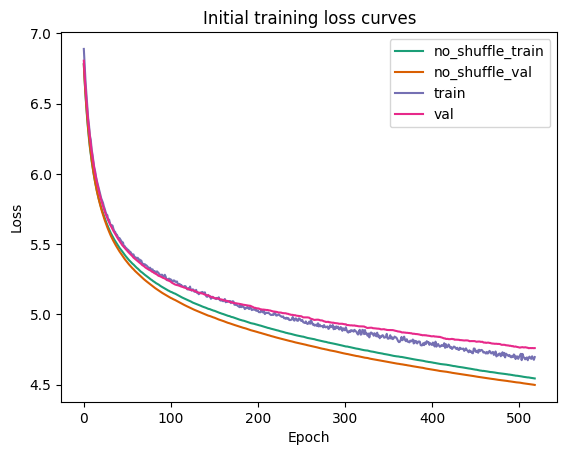

In [7]:
BETA = 1.0

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict()
train_kwargs = dict(
    loss_function=utils.fitness_softmin_loss,
    k=1024,
    lr=1e-2,
    beta=BETA, 
    negative_score_reduction='none', 
    n_epochs=3000, 
    shuffle_negatives=True, 
    bias_init_margin_ratio=0.01,
    # device=torch.device('cuda:0'), 
    # regularizer=regularizer,
    split_validation_from_train=True,
    patience_epochs=20,
    use_lr_scheduler=False,
    batch_size=4,
    )

scoring = utils.build_multiple_scoring_function(
    [utils.wrap_loss_function_to_metric(utils.fitness_sofmin_loss_positive_negative_split, dict(beta=BETA), True),  # type: ignore
     utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank, utils.evaluate_fitness_single_game_min_rank, 
     utils.wrap_loss_function_to_metric(utils.energy_of_negative_at_quantile, dict(quantile=0.01), True),  # type: ignore
     utils.wrap_loss_function_to_metric(utils.energy_of_negative_at_quantile, dict(quantile=0.05), True),  # type: ignore
     ],
    ['loss', 'overall_ecdf', 'single_game_rank', 'single_game_min_rank', 'energy_of_negative@1%', 'energy_of_negative@5%'],
)

model, (small_train_tensor, small_test_tensor), small_results = utils.initialize_and_fit_model(
    small_feature_set_tensor, split_test_set=True, 
    random_seed=DEFAULT_RANDOM_SEED,
    scaler_kwargs=scaler_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs,
    scoring_function=scoring, 
)
utils.print_results_dict(small_results)  # type: ignore
utils.plot_loss_curves(model.named_steps['fitness'].losses, 'Initial training loss curves')


In [8]:
old_model = model.named_steps['fitness'].model
new_model = utils.FitnessEnergyModel(len(large_feature_set_columns))

init_weights = utils.make_init_weight_function(0.01)
new_model.apply(init_weights)

new_model.fc1.weight.data[:, :len(small_feature_set_columns)] = old_model.fc1.weight.data
new_model.fc1.bias.data = old_model.fc1.bias.data

print(torch.all(new_model.fc1.weight.data[:, :len(small_feature_set_columns)] == old_model.fc1.weight.data), torch.all(new_model.fc1.bias.data == old_model.fc1.bias.data))
model.named_steps['fitness'].model = new_model
model.named_steps['fitness'].init_model = False


tensor(True) tensor(True)


### Train results:

{'loss': -4.068393230438232,
 'overall_ecdf': -0.01784192043103863,
 'single_game_rank': 0.9857271909713745,
 'single_game_min_rank': 0.890625,
 'energy_of_negative@1%': 23.0472469329834,
 'energy_of_negative@5%': 22.273052215576172,
 'shuffled_loss': -4.1698455810546875,
 'shuffled_overall_ecdf': -0.01784192043103863,
 'shuffled_single_game_rank': 0.9831981062889099,
 'shuffled_single_game_min_rank': 0.8408203125,
 'shuffled_energy_of_negative@1%': 23.047245025634766,
 'shuffled_energy_of_negative@5%': 22.273052215576172}

### Test results:

{'loss': -3.9120383262634277,
 'overall_ecdf': -0.025485365853658536,
 'single_game_rank': 0.987744152545929,
 'single_game_min_rank': 0.9541015625,
 'energy_of_negative@1%': 23.5322265625,
 'energy_of_negative@5%': 22.323171615600586,
 'shuffled_loss': -4.260323524475098,
 'shuffled_overall_ecdf': -0.025485365853658536,
 'shuffled_single_game_rank': 0.975830078125,
 'shuffled_single_game_min_rank': 0.8681640625,
 'shuffled_energy_of_negative@1%': 23.532222747802734,
 'shuffled_energy_of_negative@5%': 22.323169708251953}

### Combined results:

{'loss': -4.036484241485596,
 'overall_ecdf': -0.019514328379435397,
 'single_game_rank': 0.9861388206481934,
 'single_game_min_rank': 0.890625,
 'energy_of_negative@1%': 23.14337158203125,
 'energy_of_negative@5%': 22.27885627746582,
 'shuffled_loss': -4.187748432159424,
 'shuffled_overall_ecdf': -0.019514328379435397,
 'shuffled_single_game_rank': 0.9806780219078064,
 'shuffled_single_game_min_rank': 0.8447265625,
 'shuffled_energy_of_negative@1%': 23.14337158203125,
 'shuffled_energy_of_negative@5%': 22.27885627746582}

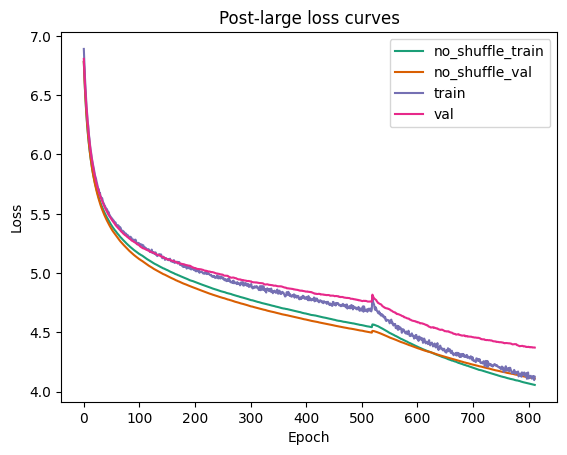

In [9]:
model, (large_train_tensor, large_test_tensor), large_results = utils.initialize_and_fit_model(
    large_feature_set_tensor, split_test_set=True, 
    random_seed=DEFAULT_RANDOM_SEED,
    scaler_kwargs=scaler_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs,
    scoring_function=scoring, 
    pipeline=model,
)

utils.print_results_dict(large_results)  # type: ignore
utils.plot_loss_curves(model.named_steps['fitness'].losses, 'Post-large loss curves')

### Train results:

{'loss': -4.215295314788818,
 'overall_ecdf': -0.02230849409085807,
 'single_game_rank': 0.9847631454467773,
 'single_game_min_rank': 0.890625,
 'energy_of_negative@1%': 18.041500091552734,
 'energy_of_negative@5%': 17.28994369506836,
 'shuffled_loss': -4.332269191741943,
 'shuffled_overall_ecdf': -0.022307852664325462,
 'shuffled_single_game_rank': 0.9779647588729858,
 'shuffled_single_game_min_rank': 0.830078125,
 'shuffled_energy_of_negative@1%': 18.0414981842041,
 'shuffled_energy_of_negative@5%': 17.289947509765625}

### Test results:

{'loss': -4.095644950866699,
 'overall_ecdf': -0.034190243902439035,
 'single_game_rank': 0.986035168170929,
 'single_game_min_rank': 0.9404296875,
 'energy_of_negative@1%': 18.530258178710938,
 'energy_of_negative@5%': 17.166751861572266,
 'shuffled_loss': -4.5250983238220215,
 'shuffled_overall_ecdf': -0.03417804878048781,
 'shuffled_single_game_rank': 0.96728515625,
 'shuffled_single_game_min_rank': 0.8251953125,
 'shuffled_energy_of_negative@1%': 18.530258178710938,
 'shuffled_energy_of_negative@5%': 17.16675567626953}

### Combined results:

{'loss': -4.190876483917236,
 'overall_ecdf': -0.02523511544986337,
 'single_game_rank': 0.9850227236747742,
 'single_game_min_rank': 0.890625,
 'energy_of_negative@1%': 18.0935115814209,
 'energy_of_negative@5%': 17.270620346069336,
 'shuffled_loss': -4.3724822998046875,
 'shuffled_overall_ecdf': -0.02523511544986337,
 'shuffled_single_game_rank': 0.9754464030265808,
 'shuffled_single_game_min_rank': 0.7861328125,
 'shuffled_energy_of_negative@1%': 18.0935115814209,
 'shuffled_energy_of_negative@5%': 17.270620346069336}

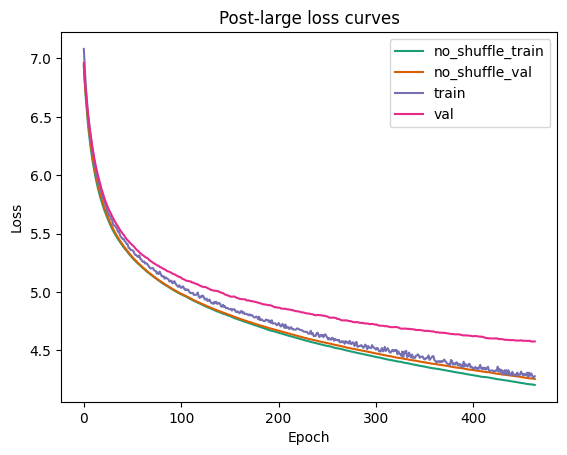

In [10]:
large_only_model, (large_only_train_tensor, large_only_test_tensor), large_only_results = utils.initialize_and_fit_model(
    large_feature_set_tensor, split_test_set=True, 
    random_seed=DEFAULT_RANDOM_SEED,
    scaler_kwargs=scaler_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs,
    scoring_function=scoring, 
)

utils.print_results_dict(large_only_results)  # type: ignore
utils.plot_loss_curves(large_only_model.named_steps['fitness'].losses, 'Post-large loss curves')

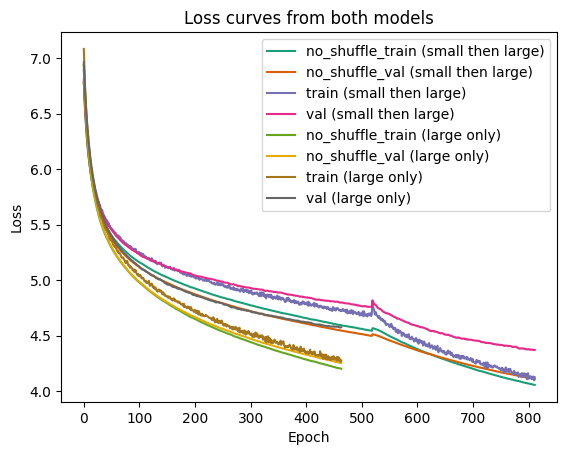

In [11]:
combined_losses = {f'{k} (small then large)': v for k, v in model.named_steps['fitness'].losses.items()}
combined_losses.update({f'{k} (large only)': v for k, v in large_only_model.named_steps['fitness'].losses.items()})

utils.plot_loss_curves(combined_losses, 'Loss curves from both models')

## Same as above but for a learning rate scheduler

### Train results:

{'loss': -4.893128395080566,
 'overall_ecdf': -0.04406520100703965,
 'single_game_rank': 0.9828851222991943,
 'single_game_min_rank': 0.8876953125,
 'energy_of_negative@1%': 11.702569007873535,
 'energy_of_negative@5%': 11.317011833190918,
 'shuffled_loss': -5.011240482330322,
 'shuffled_overall_ecdf': -0.044065040650406506,
 'shuffled_single_game_rank': 0.9573317170143127,
 'shuffled_single_game_min_rank': 0.83203125,
 'shuffled_energy_of_negative@1%': 11.702567100524902,
 'shuffled_energy_of_negative@5%': 11.317011833190918}

### Test results:

{'loss': -4.730002403259277,
 'overall_ecdf': -0.04003170731707318,
 'single_game_rank': 0.9839843511581421,
 'single_game_min_rank': 0.9375,
 'energy_of_negative@1%': 11.850772857666016,
 'energy_of_negative@5%': 11.2698974609375,
 'shuffled_loss': -4.924113750457764,
 'shuffled_overall_ecdf': -0.04003170731707318,
 'shuffled_single_game_rank': 0.96142578125,
 'shuffled_single_game_min_rank': 0.849609375,
 'shuffled_energy_of_negative@1%': 11.8507719039917,
 'shuffled_energy_of_negative@5%': 11.269898414611816}

### Combined results:

{'loss': -4.859837532043457,
 'overall_ecdf': -0.04325240499385418,
 'single_game_rank': 0.9831094741821289,
 'single_game_min_rank': 0.8876953125,
 'energy_of_negative@1%': 11.713939666748047,
 'energy_of_negative@5%': 11.31068229675293,
 'shuffled_loss': -4.99312686920166,
 'shuffled_overall_ecdf': -0.04325240499385418,
 'shuffled_single_game_rank': 0.9572703838348389,
 'shuffled_single_game_min_rank': 0.83203125,
 'shuffled_energy_of_negative@1%': 11.713939666748047,
 'shuffled_energy_of_negative@5%': 11.31068229675293}

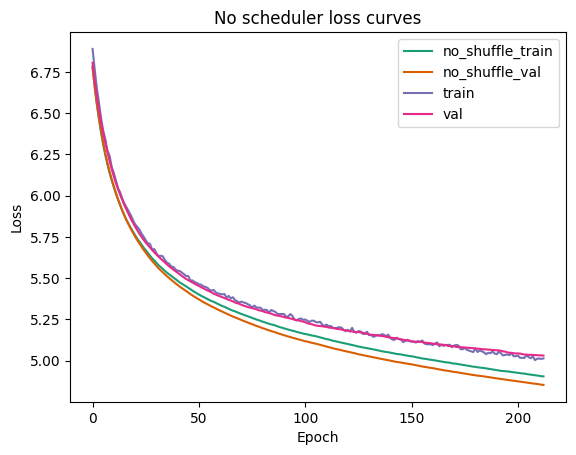

In [47]:
BETA = 1.0

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict()
train_kwargs = dict(
    loss_function=utils.fitness_softmin_loss,
    k=1024,
    lr=1e-2,
    beta=BETA, 
    negative_score_reduction='none', 
    n_epochs=3000, 
    shuffle_negatives=True, 
    bias_init_margin_ratio=0.01,
    # device=torch.device('cuda:0'), 
    # regularizer=regularizer,
    split_validation_from_train=True,
    patience_epochs=10,
    use_lr_scheduler=False,
    lr_scheduler_verbose=True,
    batch_size=4,
    )

scoring = utils.build_multiple_scoring_function(
    [utils.wrap_loss_function_to_metric(utils.fitness_sofmin_loss_positive_negative_split, dict(beta=BETA), True),  # type: ignore
     utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank, utils.evaluate_fitness_single_game_min_rank, 
     utils.wrap_loss_function_to_metric(utils.energy_of_negative_at_quantile, dict(quantile=0.01), True),  # type: ignore
     utils.wrap_loss_function_to_metric(utils.energy_of_negative_at_quantile, dict(quantile=0.05), True),  # type: ignore
     ],
    ['loss', 'overall_ecdf', 'single_game_rank', 'single_game_min_rank', 'energy_of_negative@1%', 'energy_of_negative@5%'],
)

model_no_scheduler, (no_scheduler_train_tensor, no_scheduler_test_tensor), no_scheduler_results = utils.initialize_and_fit_model(
    small_feature_set_tensor, split_test_set=True, 
    random_seed=DEFAULT_RANDOM_SEED,
    scaler_kwargs=scaler_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs,
    scoring_function=scoring, 
)
utils.print_results_dict(no_scheduler_results)  # type: ignore
utils.plot_loss_curves(model_no_scheduler.named_steps['fitness'].losses, 'No scheduler loss curves')


Epoch 00157: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00167: reducing learning rate of group 0 to 2.5000e-03.


### Train results:

{'loss': -4.987635135650635,
 'overall_ecdf': -0.04750276615192187,
 'single_game_rank': 0.9826347231864929,
 'single_game_min_rank': 0.8876953125,
 'energy_of_negative@1%': 10.271424293518066,
 'energy_of_negative@5%': 9.944454193115234,
 'shuffled_loss': -5.093830108642578,
 'shuffled_overall_ecdf': -0.047502926508555025,
 'shuffled_single_game_rank': 0.9524489045143127,
 'shuffled_single_game_min_rank': 0.8251953125,
 'shuffled_energy_of_negative@1%': 10.271425247192383,
 'shuffled_energy_of_negative@5%': 9.944453239440918}

### Test results:

{'loss': -4.83258056640625,
 'overall_ecdf': -0.04179756097560976,
 'single_game_rank': 0.9837890863418579,
 'single_game_min_rank': 0.9375,
 'energy_of_negative@1%': 10.423063278198242,
 'energy_of_negative@5%': 9.888103485107422,
 'shuffled_loss': -4.9976420402526855,
 'shuffled_overall_ecdf': -0.041775609756097565,
 'shuffled_single_game_rank': 0.958544909954071,
 'shuffled_single_game_min_rank': 0.8662109375,
 'shuffled_energy_of_negative@1%': 10.423063278198242,
 'shuffled_energy_of_negative@5%': 9.888104438781738}

### Combined results:

{'loss': -4.955990314483643,
 'overall_ecdf': -0.046387683993458,
 'single_game_rank': 0.9828702807426453,
 'single_game_min_rank': 0.8876953125,
 'energy_of_negative@1%': 10.29222297668457,
 'energy_of_negative@5%': 9.936332702636719,
 'shuffled_loss': -5.074213981628418,
 'shuffled_overall_ecdf': -0.046387683993458,
 'shuffled_single_game_rank': 0.9541513919830322,
 'shuffled_single_game_min_rank': 0.8330078125,
 'shuffled_energy_of_negative@1%': 10.29222297668457,
 'shuffled_energy_of_negative@5%': 9.936332702636719}

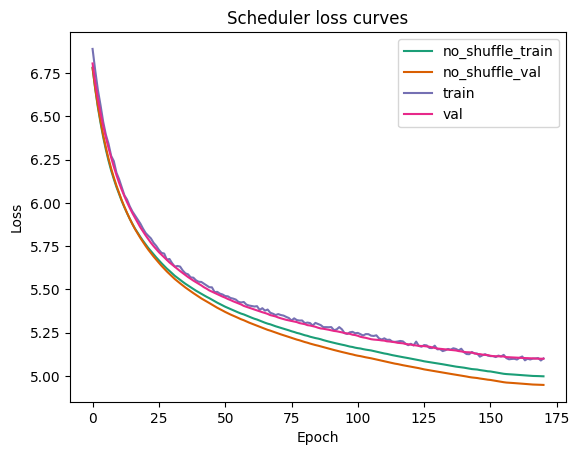

In [48]:
train_kwargs['use_lr_scheduler'] = True
# train_kwargs['patience_epochs'] = 20


model_scheduler, (scheduler_train_tensor, scheduler_test_tensor), scheduler_results = utils.initialize_and_fit_model(
    small_feature_set_tensor, split_test_set=True, 
    random_seed=DEFAULT_RANDOM_SEED,
    scaler_kwargs=scaler_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs,
    scoring_function=scoring, 
)
utils.print_results_dict(scheduler_results)  # type: ignore
utils.plot_loss_curves(model_scheduler.named_steps['fitness'].losses, 'Scheduler loss curves')


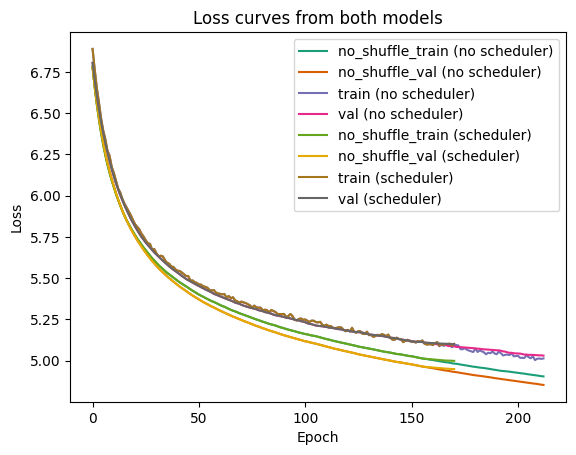

In [49]:
combined_losses = {f'{k} (no scheduler)': v for k, v in model_no_scheduler.named_steps['fitness'].losses.items()}
combined_losses.update({f'{k} (scheduler)': v for k, v in model_scheduler.named_steps['fitness'].losses.items()})

utils.plot_loss_curves(combined_losses, 'Loss curves from both models')

## Explicitly trying different numbers of features

In [18]:
BETA = 1.0

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict()
train_kwargs = dict(
    loss_function=utils.fitness_softmin_loss,
    k=1024,
    lr=3e-4,
    beta=BETA, 
    negative_score_reduction='none', 
    n_epochs=5000, 
    shuffle_negatives=True, 
    bias_init_margin_ratio=0.01,
    # device=torch.device('cuda:0'), 
    # regularizer=regularizer,
    split_validation_from_train=True,
    use_lr_scheduler=False,
    lr_scheduler_verbose=True,
    batch_size=4,
    patience_epochs=5000,
    random_seed=3333,
    )

scoring = utils.build_multiple_scoring_function(
    [utils.wrap_loss_function_to_metric(utils.fitness_sofmin_loss_positive_negative_split, dict(beta=BETA), True),  # type: ignore
     utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank, utils.evaluate_fitness_single_game_min_rank, 
     utils.wrap_loss_function_to_metric(utils.energy_of_negative_at_quantile, dict(quantile=0.01), True),  # type: ignore
     utils.wrap_loss_function_to_metric(utils.energy_of_negative_at_quantile, dict(quantile=0.05), True),  # type: ignore
     ],
    ['loss', 'overall_ecdf', 'single_game_rank', 'single_game_min_rank', 'energy_of_negative@1%', 'energy_of_negative@5%'],
)

n_features_losses = {}
n_features_results = {}

for score_thresold in tqdm.tqdm(reversed([0, 0.005, 0.01, 0.02, 0.03, 0.04])):
    features = get_features_by_abs_diff_threshold(abs_diffs, score_thresold)
    features_model, (features_train_tensor, features_test_tensor), features_results = utils.initialize_and_fit_model(
        fitness_df, feature_columns=features,
        split_test_set=True, 
        random_seed=DEFAULT_RANDOM_SEED,
        scaler_kwargs=scaler_kwargs, model_kwargs=model_kwargs, train_kwargs=train_kwargs,
        scoring_function=scoring,)
    
    display(Markdown(f'## {len(features)} features'))
    utils.print_results_dict(features_results, ['test'])  # type: ignore
    n = len(features)
    n_features_losses[n] = features_model.named_steps['fitness'].losses
    n_features_results[n] = features_results

0it [00:00, ?it/s]

Training finished without early stopping


## 31 features

### Test results:

{'loss': -4.857123851776123,
 'overall_ecdf': -0.04327560975609757,
 'single_game_rank': 0.9842284917831421,
 'single_game_min_rank': 0.9375,
 'energy_of_negative@1%': 10.393692970275879,
 'energy_of_negative@5%': 9.788259506225586,
 'shuffled_loss': -5.009659290313721,
 'shuffled_overall_ecdf': -0.04327560975609757,
 'shuffled_single_game_rank': 0.957275390625,
 'shuffled_single_game_min_rank': 0.8388671875,
 'shuffled_energy_of_negative@1%': 10.393692016601562,
 'shuffled_energy_of_negative@5%': 9.78825855255127}

1it [03:06, 186.07s/it]

Training finished without early stopping


## 46 features

### Test results:

{'loss': -4.782063961029053,
 'overall_ecdf': -0.03083170731707317,
 'single_game_rank': 0.9859374761581421,
 'single_game_min_rank': 0.958984375,
 'energy_of_negative@1%': 10.54554557800293,
 'energy_of_negative@5%': 10.094377517700195,
 'shuffled_loss': -4.880651473999023,
 'shuffled_overall_ecdf': -0.030831707317073177,
 'shuffled_single_game_rank': 0.969287097454071,
 'shuffled_single_game_min_rank': 0.8515625,
 'shuffled_energy_of_negative@1%': 10.54554557800293,
 'shuffled_energy_of_negative@5%': 10.094376564025879}

2it [06:18, 189.71s/it]

Training finished without early stopping


## 72 features

### Test results:

{'loss': -4.772772789001465,
 'overall_ecdf': -0.03754634146341464,
 'single_game_rank': 0.98291015625,
 'single_game_min_rank': 0.9130859375,
 'energy_of_negative@1%': 10.233457565307617,
 'energy_of_negative@5%': 9.706117630004883,
 'shuffled_loss': -4.905054092407227,
 'shuffled_overall_ecdf': -0.037541463414634144,
 'shuffled_single_game_rank': 0.962841808795929,
 'shuffled_single_game_min_rank': 0.7919921875,
 'shuffled_energy_of_negative@1%': 10.233457565307617,
 'shuffled_energy_of_negative@5%': 9.70611572265625}

3it [10:47, 226.08s/it]

Training finished without early stopping


## 124 features

### Test results:

{'loss': -4.69313383102417,
 'overall_ecdf': -0.037529268292682924,
 'single_game_rank': 0.984667956829071,
 'single_game_min_rank': 0.92578125,
 'energy_of_negative@1%': 10.749073028564453,
 'energy_of_negative@5%': 10.048437118530273,
 'shuffled_loss': -4.864019870758057,
 'shuffled_overall_ecdf': -0.03752926829268293,
 'shuffled_single_game_rank': 0.961376965045929,
 'shuffled_single_game_min_rank': 0.783203125,
 'shuffled_energy_of_negative@1%': 10.749073028564453,
 'shuffled_energy_of_negative@5%': 10.048437118530273}

4it [17:24, 293.33s/it]

Training finished without early stopping


## 172 features

### Test results:

{'loss': -4.643359184265137,
 'overall_ecdf': -0.04114146341463415,
 'single_game_rank': 0.983593761920929,
 'single_game_min_rank': 0.9111328125,
 'energy_of_negative@1%': 10.763564109802246,
 'energy_of_negative@5%': 10.094873428344727,
 'shuffled_loss': -4.8395891189575195,
 'shuffled_overall_ecdf': -0.04114146341463415,
 'shuffled_single_game_rank': 0.957812488079071,
 'shuffled_single_game_min_rank': 0.7646484375,
 'shuffled_energy_of_negative@1%': 10.763565063476562,
 'shuffled_energy_of_negative@5%': 10.094873428344727}

5it [25:50, 370.24s/it]

Training finished without early stopping


## 324 features

### Test results:

{'loss': -4.596062660217285,
 'overall_ecdf': -0.03645121951219512,
 'single_game_rank': 0.985595703125,
 'single_game_min_rank': 0.935546875,
 'energy_of_negative@1%': 12.141646385192871,
 'energy_of_negative@5%': 11.415983200073242,
 'shuffled_loss': -4.740701198577881,
 'shuffled_overall_ecdf': -0.036429268292682934,
 'shuffled_single_game_rank': 0.961962878704071,
 'shuffled_single_game_min_rank': 0.7900390625,
 'shuffled_energy_of_negative@1%': 12.141647338867188,
 'shuffled_energy_of_negative@5%': 11.415983200073242}

6it [38:59, 389.86s/it]


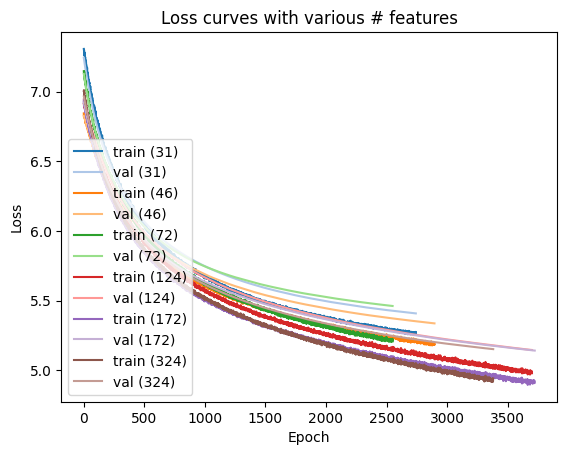

In [16]:
keys = ('train', 'val',)
n_values = list(n_features_losses.keys())
feature_losses = {f'{k} ({n})': n_features_losses[n][k] for n in n_values for k in keys}

utils.plot_loss_curves(feature_losses, 'Loss curves with various # features', cmap='tab20',
                       legend_loc='lower left')

In [17]:
rows = [
    [f'**{n}**'] + [abs(n_features_results[n][key][metric])
                    for metric in ('loss', 'shuffled_loss', 'overall_ecdf')
                    for key in ('train', 'test') ]
    for n in n_values
]

display(Markdown(tabulate.tabulate(rows, headers=['n', 'train loss', 'test loss', 'train shuffled loss', 'test shuffled loss',  'train ecdf', 'test ecdf'], tablefmt='github')))





| n       |   train loss |   test loss |   train shuffled loss |   test shuffled loss |   train ecdf |   test ecdf |
|---------|--------------|-------------|-----------------------|----------------------|--------------|-------------|
| **31**  |      5.22584 |     5.09892 |               5.29727 |              5.19203 |    0.053473  |   0.0463341 |
| **46**  |      5.14349 |     5.01089 |               5.22098 |              5.09059 |    0.0468695 |   0.0354927 |
| **72**  |      5.17257 |     5.07432 |               5.27058 |              5.1553  |    0.053781  |   0.0418268 |
| **124** |      4.95018 |     4.84092 |               5.02014 |              4.97404 |    0.0351069 |   0.0387024 |
| **172** |      4.89505 |     4.78756 |               4.96205 |              4.94511 |    0.0331985 |   0.0421659 |
| **324** |      4.91842 |     4.80653 |               4.97594 |              4.89337 |    0.0330137 |   0.0360732 |

# Checking configurations

In [6]:
BETA = 1.0
N_WORKERS = 4
CHUNKSIZE = 10

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict()
train_kwargs = dict(
    loss_function=utils.fitness_softmin_loss,
    k=1024,
    lr=4e-3,
    beta=BETA, 
    negative_score_reduction='none', 
    n_epochs=10000, 
    shuffle_negatives=True, 
    bias_init_margin_ratio=0.01,
    device=torch.device('cuda:0'), 
    # regularizer=regularizer,
    split_validation_from_train=True,
    )

sweep_param_grid = dict(
    patience_epochs=range(50, 300, 50),
    use_lr_scheduler=[False, True],
    batch_size=[1, 2, 4, 8, 16], # batch_size=[1, 2, 4, 8, 16],
    score_threshold=[0, 0.005, 0.01, 0.02, 0.03, 0.04], # score_threshold=[0, 0.005, 0.01, 0.02, 0.03, 0.04],
)

scoring = utils.build_multiple_scoring_function(
    [utils.wrap_loss_function_to_metric(utils.fitness_sofmin_loss_positive_negative_split, dict(beta=BETA), True),  # type: ignore
     utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank, utils.evaluate_fitness_single_game_min_rank, 
     utils.wrap_loss_function_to_metric(utils.energy_of_negative_at_quantile, dict(quantile=0.01), True),  # type: ignore
     utils.wrap_loss_function_to_metric(utils.energy_of_negative_at_quantile, dict(quantile=0.05), True),  # type: ignore
     ],
    ['loss', 'overall_ecdf', 'single_game_rank', 'single_game_min_rank', 'energy_of_negative@1%', 'energy_of_negative@5%'],
)

mean_features_by_real = fitness_df[['real'] + [c for c in fitness_df.columns if c not in NON_FEATURE_COLUMNS]].groupby('real').mean()
feature_diffs = mean_features_by_real.loc[1] - mean_features_by_real.loc[0]
abs_diffs = feature_diffs.abs()  # .sort_values(ascending=False)

sweep_models = {}
sweep_results = {}
sweep_losses = {}

def fit_configuration(setting_kwargs):
    setting_key = list(setting_kwargs.values()) 

    setting_train_kwargs = train_kwargs.copy()
    score_threshold = setting_kwargs.pop('score_threshold')
    setting_train_kwargs.update(setting_kwargs)

    feature_columns = get_features_by_abs_diff_threshold(abs_diffs, score_threshold)

    model, _, results = utils.initialize_and_fit_model(
        fitness_df, split_test_set=True, feature_columns=feature_columns,
        random_seed=DEFAULT_RANDOM_SEED,
        scaler_kwargs=scaler_kwargs, model_kwargs=model_kwargs, train_kwargs=setting_train_kwargs,
        scoring_function=scoring, 
    )
    
    setting_key.append(len(feature_columns))
    setting_key = tuple(setting_key)
    sweep_models[setting_key] = model
    sweep_results[setting_key] = results
    sweep_losses[setting_key] = model.named_steps['fitness'].losses


def param_combination_iterator():
    for combination in itertools.product(*sweep_param_grid.values()):  # type: ignore
        yield dict(zip(sweep_param_grid.keys(), combination))


for setting_kwargs in tqdm.tqdm(param_combination_iterator(), total=np.product([len(v) for v in sweep_param_grid.values()])):  # type: ignore
    fit_configuration(setting_kwargs)


# with multiprocessing.Pool(N_WORKERS) as p:
#     for row in tqdm.tqdm(p.imap_unordered(fit_configuration, param_combination_iterator(), chunksize=CHUNKSIZE), total=np.product([len(v) for v in sweep_param_grid.values()])):  # type: ignore
#         continue
    

KEY_HEADERS = ['patience_epochs', 'use_lr_scheduler', 'batch_size', 'score_threshold', 'n_features']
example_values = next(iter(sweep_results.values()))
VALUE_HEADERS = [f'{outer_key}_{inner_key}' for outer_key in example_values for inner_key in example_values[outer_key]]

rows = [list(key) + [results[outer_key][inner_key] for outer_key in results for inner_key in results[outer_key]]
        for key, results in sweep_results.items()]

sweep_results_df = pd.DataFrame(rows, columns=KEY_HEADERS + VALUE_HEADERS)
sweep_results_df = sweep_results_df.assign(**{c: sweep_results_df[c].abs() for c in sweep_results_df.columns if 'ecdf' in c or 'loss' in c or 'energy_of_negative' in c}, 
                                           use_lr_scheduler=sweep_results_df.use_lr_scheduler.astype(int))
sweep_results_df.head()



  0%|          | 1/300 [01:21<6:48:22, 81.95s/it]


KeyboardInterrupt: 

In [7]:
with gzip.open('../tmp/sweep_results_large_44_no_patience.pkl.gz', 'rb') as f:
    full_sweep_results = pickle.load(f)

sweep_results_df = full_sweep_results['sweep_results_df']
sweep_models = full_sweep_results['sweep_models']
sweep_losses = full_sweep_results['sweep_losses']

In [8]:
sweep_results_df = sweep_results_df.assign(train_end_train_loss=0, train_end_val_loss=0)
for k in sweep_losses.keys():
    sweep_results_df.loc[(sweep_results_df.patience_epochs == k[0]) & (sweep_results_df.use_lr_scheduler == int(k[1])) & (sweep_results_df.batch_size == k[2]) & (sweep_results_df.n_features == k[4]), 'train_end_train_loss'] = sweep_losses[k]['train'][-1]
    sweep_results_df.loc[(sweep_results_df.patience_epochs == k[0]) & (sweep_results_df.use_lr_scheduler == int(k[1])) & (sweep_results_df.batch_size == k[2]) & (sweep_results_df.n_features == k[4]), 'train_end_val_loss'] = sweep_losses[k]['val'][-1]

In [15]:
NAME_MAPPINGS = {
    'patience_epochs': 'Patience Epochs',
    'n_features': '# of Features Used',
    'use_lr_scheduler': 'Use LR Scheduler',
    'batch_size': 'Batch Size',
    'train_ecdf': 'Train ECDF',
    'test_ecdf': 'Test ECDF',
    'train_game_rank': 'Train Game Rank',
    'test_game_rank': 'Test Game Rank',
}


def plot_sweep_results(
    results_df: pd.DataFrame, 
    x_key: str, 
    color_by_key: str,
    column_by_key: typing.Optional[str] = None,
    row_by_key: typing.Optional[str] = None,
    filter_conditions: typing.Optional[typing.Dict[str, typing.Any]] = None,
    legend_ax_index: int = 0,
    name_mappings: typing.Dict[str, str] = NAME_MAPPINGS,
    metrics: typing.List[str] = ['train_overall_ecdf', 'test_overall_ecdf'],
    cmap_name: str = 'tab20',
    ylabel: typing.Optional[str] = None,
    show_ax_titles: bool = True,
    subplot_adjust_params: typing.Optional[typing.Dict[str, float]] = None,
    suptitle: typing.Optional[str] = None,
    ):

    color_values = list(sorted(results_df[color_by_key].unique()))
    x_values = list(sorted(results_df[x_key].unique()))

    column_values = []
    if column_by_key is not None:
        column_values = list(sorted(results_df[column_by_key].unique()))

    row_values = []
    if row_by_key is not None:
        row_values = list(sorted(results_df[row_by_key].unique()))

    if filter_conditions is not None:
        row_filter = np.ones(len(results_df), dtype=bool)
        for col, val in filter_conditions.items():
            row_filter &= (results_df[col] == val)

        df = results_df[row_filter]
    else:
        df = results_df


    groupby_fields = []
    n_rows = n_columns = 1

    if row_by_key is not None:
        groupby_fields.append(row_by_key)
        n_rows = len(row_values)

    if column_by_key is not None:
        groupby_fields.append(column_by_key)
        n_columns = len(column_values)
        
    groupby_fields.append(color_by_key)
    groupby_fields.append(x_key)    
    results_groupby = df.groupby(groupby_fields)[metrics].mean()

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(6 * n_columns, 4 * n_rows), squeeze=False)
    cmap = plt.get_cmap(cmap_name)  # type: ignore

    for row_index, row_axes in enumerate(axes):
        row_value = None if row_by_key is None else row_values[row_index]
        for col_index, ax in enumerate(row_axes):
            col_value = None if column_by_key is None else column_values[col_index]
            
            for color_index, color_value in enumerate(color_values):
                key = []
                if row_value is not None: key.append(row_value)
                if col_value is not None: key.append(col_value)
                key.append(color_value)

                for metric_index, metric in enumerate(metrics):
                    y_values = [results_groupby.loc[tuple(key + [x])][metric] for x in x_values]
                    ax.plot(x_values, y_values, marker='o', linestyle='--', linewidth=2, 
                            color=cmap(color_index * len(metrics) + metric_index), 
                            label=name_mappings.get(color_value, color_value) if metric_index == 0 else None)

            ax.set_xlabel(name_mappings.get(x_key, x_key))
            if col_index == 0: ax.set_ylabel(ylabel if ylabel is not None else name_mappings.get(metrics[0], metrics[0]))
            ax.set_xticks(x_values)
            ax.set_xticklabels(x_values)
            if (row_index * n_columns) + col_index  == legend_ax_index: ax.legend()
            if show_ax_titles and column_by_key is not None: ax.set_title(f'{name_mappings.get(column_by_key, column_by_key)}={col_value}')

    ylim_min = min(ax.get_ylim()[0] for ax in itertools.chain.from_iterable(axes))
    ylim_max = max(ax.get_ylim()[1] for ax in itertools.chain.from_iterable(axes))
    for ax in itertools.chain.from_iterable(axes):
        ax.set_ylim(ylim_min, ylim_max)

    if subplot_adjust_params is not None:
        plt.subplots_adjust(**subplot_adjust_params)

    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)



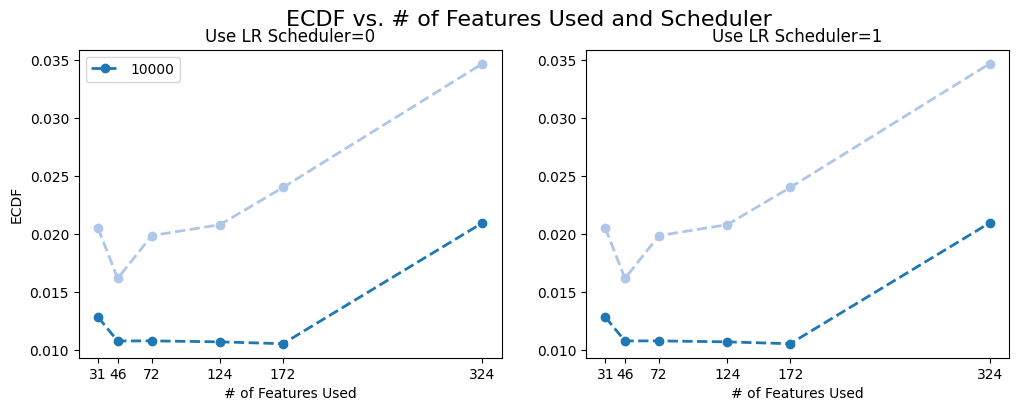

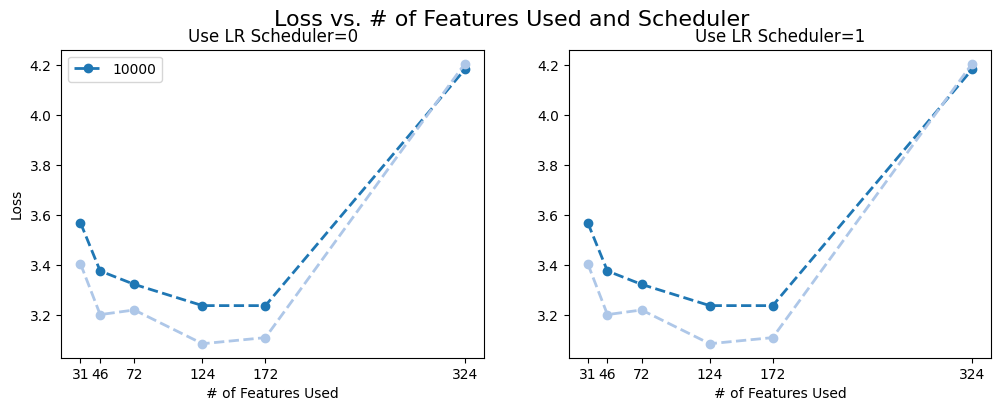

In [10]:
plot_sweep_results(sweep_results_df, 'n_features', 'patience_epochs', 
    column_by_key='use_lr_scheduler',
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    ylabel='ECDF',
    suptitle='ECDF vs. # of Features Used and Scheduler')

plot_sweep_results(sweep_results_df, 'n_features', 'patience_epochs', 
    column_by_key='use_lr_scheduler',
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    metrics=['train_loss', 'test_loss'],
    ylabel='Loss',
    suptitle='Loss vs. # of Features Used and Scheduler')

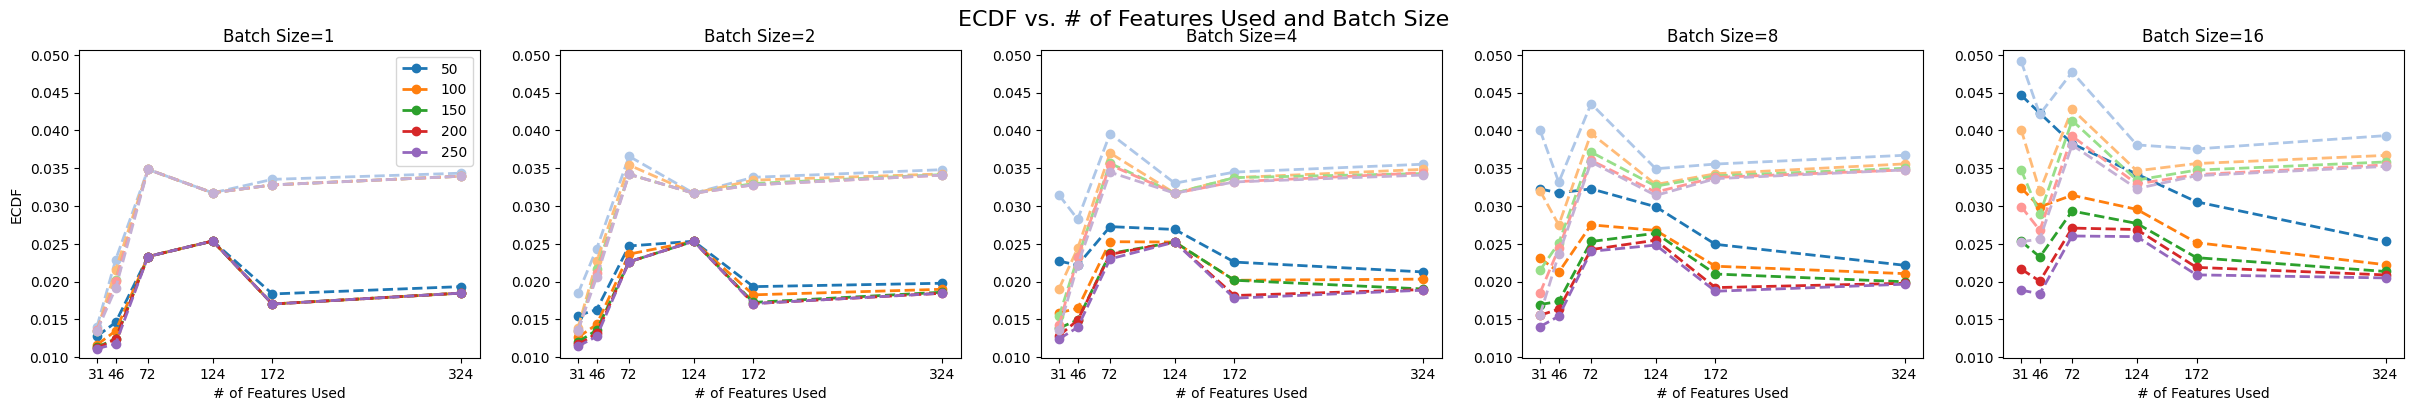

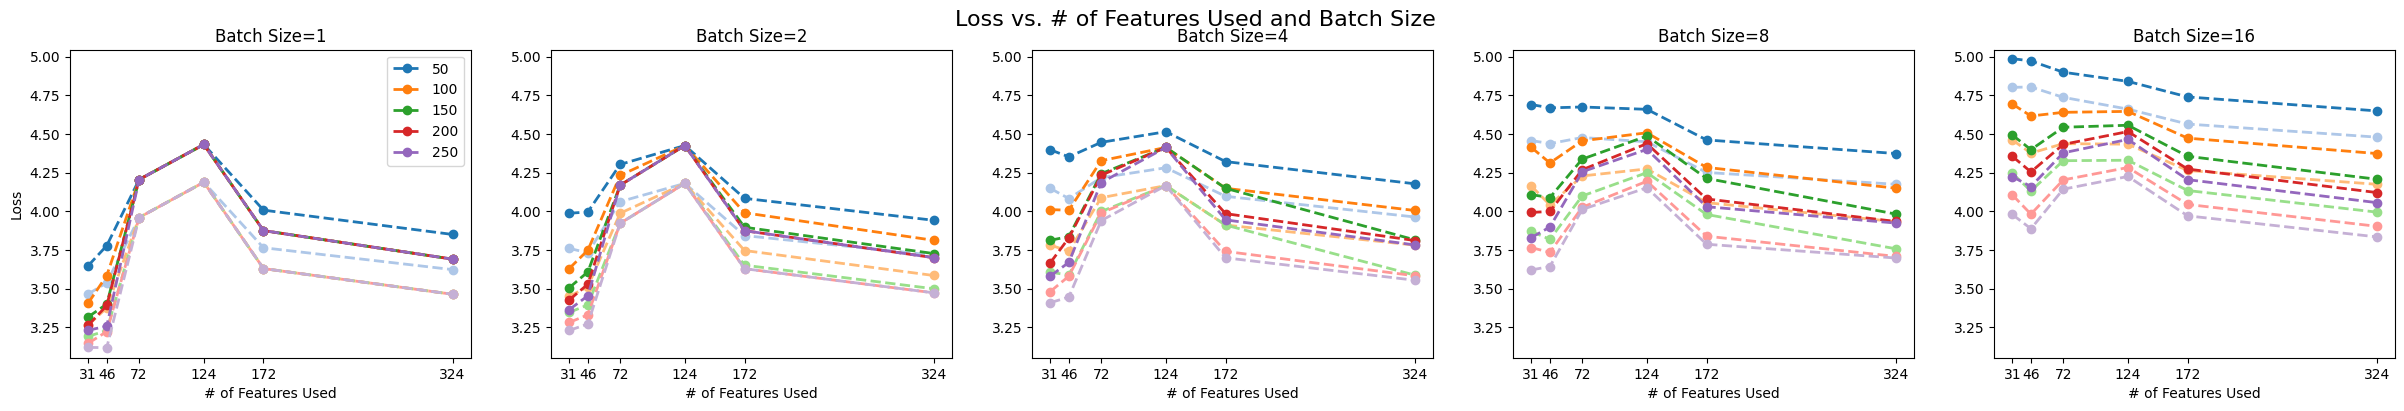

In [29]:
plot_sweep_results(sweep_results_df, 'n_features', 'patience_epochs', 
    column_by_key='batch_size',
    filter_conditions=dict(use_lr_scheduler=False),
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    ylabel='ECDF',
    suptitle='ECDF vs. # of Features Used and Batch Size')

plot_sweep_results(sweep_results_df, 'n_features', 'patience_epochs', 
    column_by_key='batch_size',
    filter_conditions=dict(use_lr_scheduler=False),
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    metrics=['train_loss', 'test_loss'],
    ylabel='Loss',
    suptitle='Loss vs. # of Features Used and Batch Size')

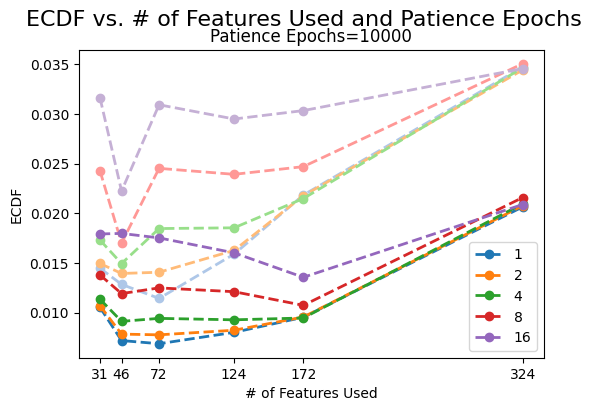

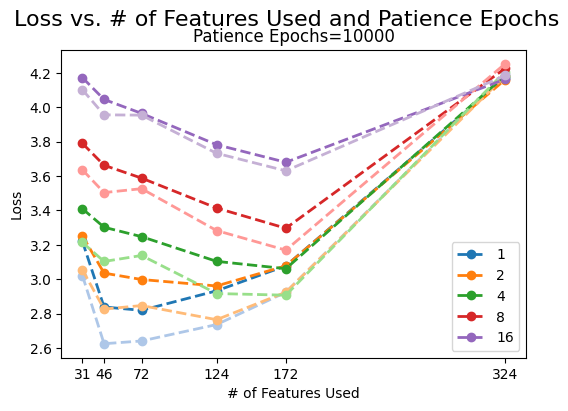

In [11]:
plot_sweep_results(sweep_results_df, 'n_features', 'batch_size', 
    column_by_key='patience_epochs',
    filter_conditions=dict(use_lr_scheduler=False),
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    ylabel='ECDF',
    suptitle='ECDF vs. # of Features Used and Patience Epochs')


plot_sweep_results(sweep_results_df, 'n_features', 'batch_size', 
    column_by_key='patience_epochs',
    filter_conditions=dict(use_lr_scheduler=False),
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    metrics=['train_loss', 'test_loss'],
    ylabel='Loss',
    suptitle='Loss vs. # of Features Used and Patience Epochs')


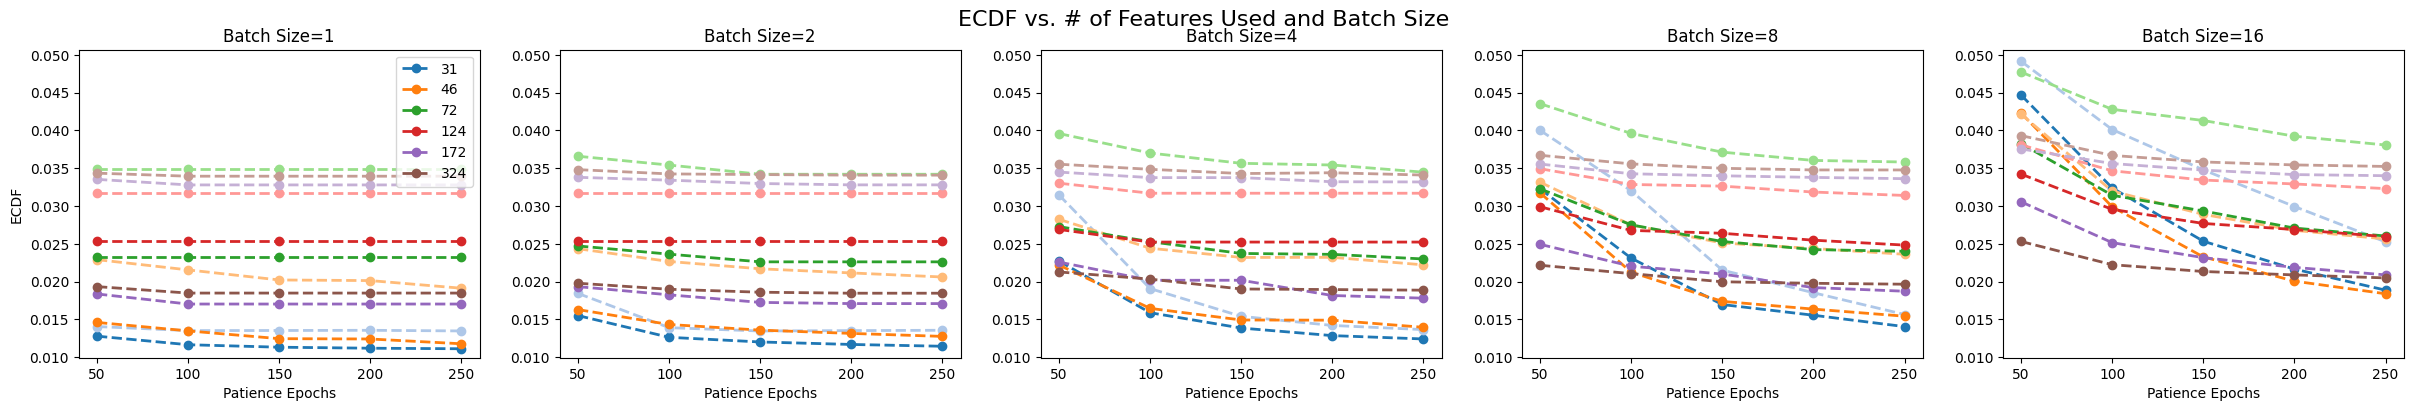

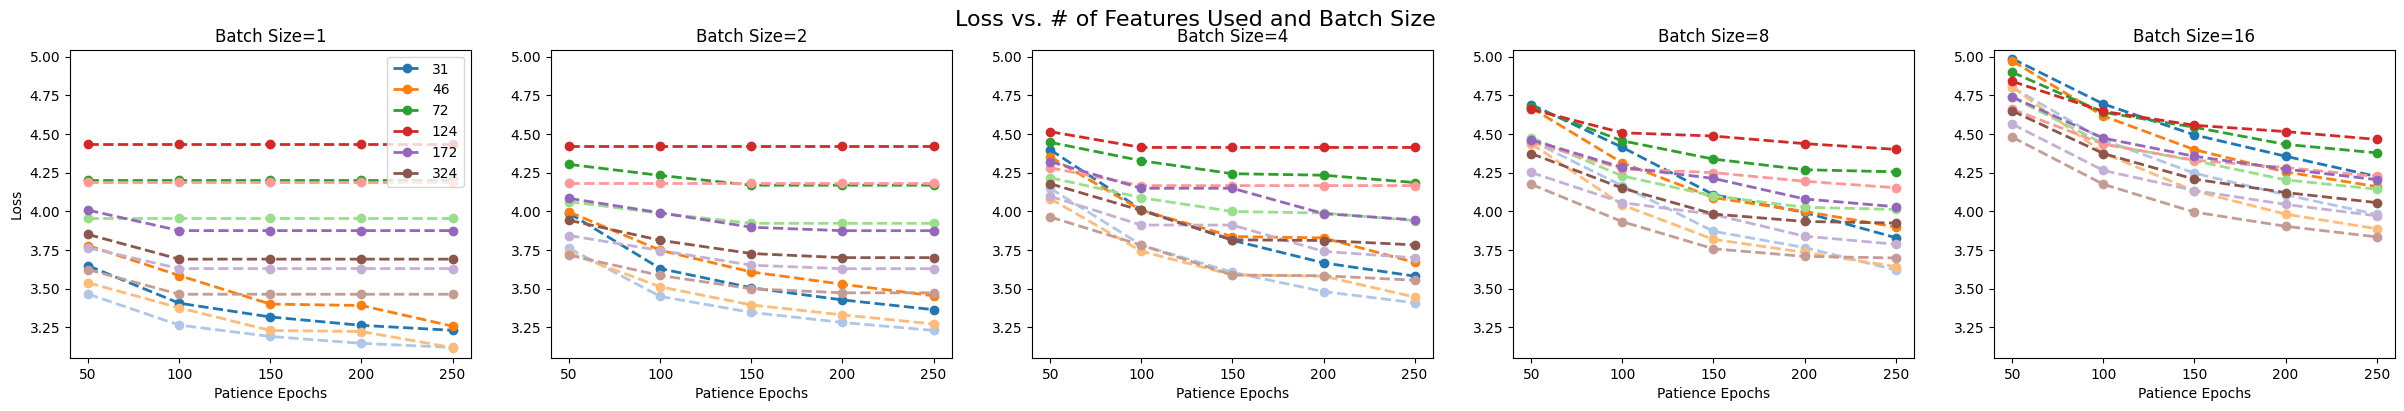

In [31]:
plot_sweep_results(sweep_results_df, 'patience_epochs', 'n_features', 
    column_by_key='batch_size',
    filter_conditions=dict(use_lr_scheduler=False),
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    ylabel='ECDF',
    suptitle='ECDF vs. # of Features Used and Batch Size')

plot_sweep_results(sweep_results_df, 'patience_epochs',  'n_features', 
    column_by_key='batch_size',
    filter_conditions=dict(use_lr_scheduler=False),
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    metrics=['train_loss', 'test_loss'],
    ylabel='Loss',
    suptitle='Loss vs. # of Features Used and Batch Size')

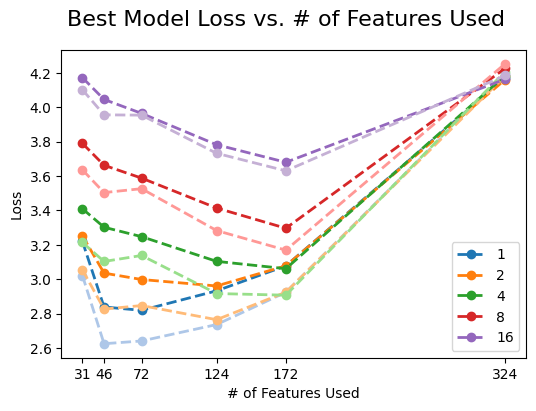

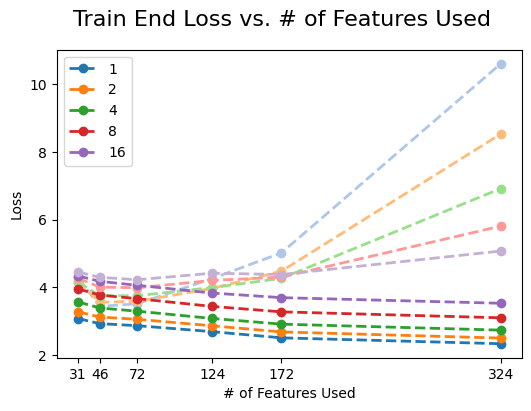

In [16]:
plot_sweep_results(sweep_results_df, 'n_features', 'batch_size', 
    # column_by_key='patience_epochs',
    filter_conditions=dict(use_lr_scheduler=False),
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    metrics=['train_loss', 'test_loss'],
    ylabel='Loss',
    suptitle='Best Model Loss vs. # of Features Used')


plot_sweep_results(sweep_results_df, 'n_features', 'batch_size', 
    # column_by_key='patience_epochs',
    filter_conditions=dict(use_lr_scheduler=False),
    subplot_adjust_params=dict(wspace=0.2, hspace=0.25),
    metrics=['train_end_train_loss', 'train_end_val_loss'],
    ylabel='Loss',
    suptitle='Train End Loss vs. # of Features Used')


In [18]:
t = torch.rand((4, 9))
t

tensor([[0.5309, 0.2819, 0.1488, 0.4639, 0.1790, 0.0740, 0.2802, 0.3844, 0.9491],
        [0.1545, 0.8267, 0.8049, 0.6826, 0.2578, 0.0523, 0.1517, 0.6821, 0.7241],
        [0.1911, 0.4350, 0.5711, 0.5840, 0.7271, 0.3337, 0.7112, 0.9537, 0.7165],
        [0.2308, 0.7773, 0.8808, 0.5852, 0.2822, 0.4499, 0.5585, 0.5619, 0.6819]])

In [30]:
torch.roll(t[:, 0].unsqueeze(1), 1, 0)

tensor([[0.2308],
        [0.5309],
        [0.1545],
        [0.1911]])

In [28]:
loss = 0
loss += nn.functional.cross_entropy(torch.cat([torch.roll(t[:, 0], 3, 0).unsqueeze(1), t[:, 1:]], 1), torch.zeros(4, dtype=torch.long))
loss

tensor(2.4449)